# IMPORTING RELEVANT LIBRARIES

In [45]:
import os # for file exploration
import numpy as np # going to load labels as numpy arrays
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely # for polygon ops
import supervision as sv # for calc iou
import statistics # for some stats
from PIL import Image # for plotting images
import matplotlib.patches as patches # for plotting bounding boxes
from sklearn.metrics import precision_recall_curve, average_precision_score # for precision recall curves

# ANALYSING NUMBER OF INSTANCES PER IMAGE

In [4]:
label_folder = r"C:\Nupoor\srip_prereq\labels\labels_native"
image_folder = r"C:\Nupoor\srip_prereq\image_chips_native"

In [18]:
label_fn = os.listdir(label_folder)
num_sp = 0 # total number of sp
class_count = {} # counting number of instances per category
num_per_im = {0:0} # counting number of sp instances per image
num_ims = []
for fn in label_fn:
    fp = os.path.join(label_folder, fn)
    with open(fp, "r") as fh:
        labels = np.loadtxt(fh, ndmin=2)
        if np.size(labels)!=0:
            if np.shape(labels)[0] not in num_per_im.keys():
                num_per_im[np.shape(labels)[0]] = 1
            else:
                num_per_im[np.shape(labels)[0]] += 1
            for label in labels:
                num_sp+=1
                if label[0] in class_count.keys():
                    class_count[label[0]]+=1
                else:
                    class_count[label[0]] = 1
        else:
            num_per_im[0]+=1
        num_ims.append(num_sp)

Label: 0.0  Count: 29267
Label: 2.0  Count: 228
Label: 1.0  Count: 130
Total number of solar panel instances = 29625
Total number of images = 2542


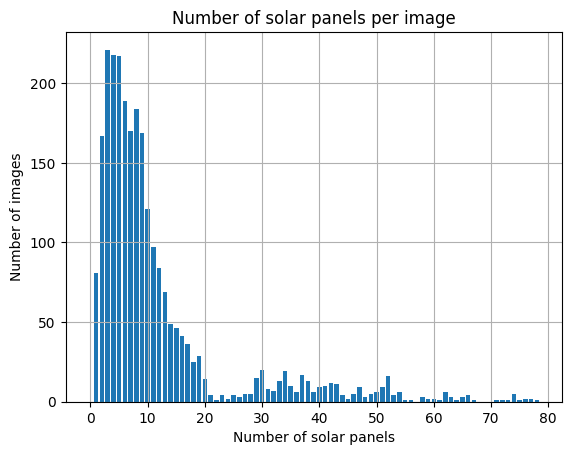

Average number of solar panel instance per image = 11.65


In [32]:
for la in class_count.keys():
    print(f"Label: {la}  Count: {class_count[la]}")
x = dict(sorted(num_per_im.items()))
print(f"Total number of solar panel instances = {num_sp}")
print(f"Total number of images = {len(label_fn)}")
plt.bar(list(x.keys()), list(x.values()))
plt.xlabel('Number of solar panels')
plt.ylabel('Number of images')
plt.title('Number of solar panels per image')
plt.grid(True)
plt.show()
print(f"Average number of solar panel instance per image = {round((num_sp/len(label_fn)), 2)}")

# FUNCTIONS FOR CALCULATING AREA AND IOU

In [37]:
# native: 31 cm per pixel, 416 X 416 pixels
def convert_to_xyxy(box): # box: [label, x_center, y_center, width, height], YOLO aa format
    x_center, y_center, width, height = box[1], box[2], box[3], box[4]
    x_min = (x_center - width / 2) * 416 # scaling to image size
    y_min = (y_center - height / 2) * 416
    x_max = (x_center + width / 2) * 416
    y_max = (y_center + height / 2) * 416
    return [x_min, y_min, x_max, y_max]

def area_in_m(a):
    al = convert_to_xyxy(a)
    apol = shapely.Polygon.from_bounds(al[0], al[1], al[2], al[3])
    area_in_m = 0.31*0.31*(apol.area)
    return area_in_m

def calc_iou(a, b, xy): # a and b are bounding boxes, xy to check if in yolo or coco
    if not xy:
        al = convert_to_xyxy(a)
        bl = convert_to_xyxy(b)
    else:
        al = a
        bl = b
    apol = shapely.Polygon.from_bounds(al[0], al[1], al[2], al[3])
    bpol = shapely.Polygon.from_bounds(bl[0], bl[1], bl[2], bl[3])
    inter = apol.intersection(bpol)
    uni = apol.union(bpol)
    iou = inter.area/uni.area
    return iou
    

# ANALYSING AREA OF SOLAR PANELS IN THE DATASET

In [8]:
areas = []
for fn in label_fn:
    fp = os.path.join(label_folder, fn)
    with open(fp, "r") as fh:
        labels = np.loadtxt(fh, ndmin=2)
        if np.size(labels)!=0:
            for label in labels:
                areas.append(area_in_m(label))

In [17]:
print(f"Mean are of a solar panel = {statistics.mean(areas)}")
print(f"standard deviation in areas of solar panels = {statistics.stdev(areas)}")
print(f"Maximum area of any solar panel = {max(areas)}")
print(f"Minimum area of any solar panel = {min(areas)}")

Mean are of a solar panel = 191.51782786497893
standard deviation in areas of solar panels = 630.7109805509049
Maximum area of any solar panel = 12177.407600000004
Minimum area of any solar panel = 1.0571000000000002


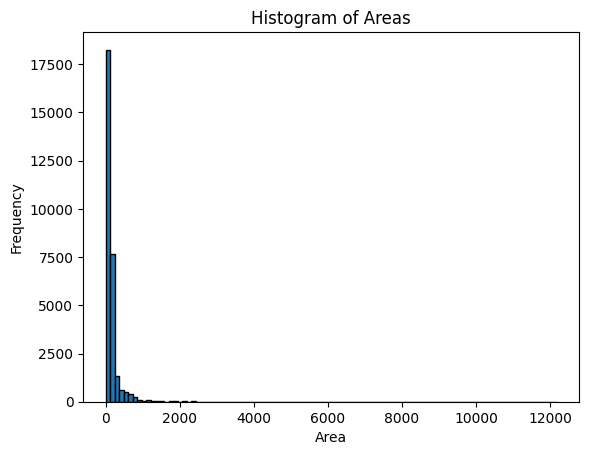

In [12]:
plt.hist(areas, bins=100, edgecolor='black')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Areas')
plt.show()

In [29]:
im_index = areas.index(max(areas))+1
for i in range(len(num_ims)):
    if num_ims[i] >= im_index:
        im_index = i
        break
max_area_lab_file = label_fn[im_index]
max_area_im_file = max_area_lab_file.rstrip("txt") + "tif"
im_index = areas.index(min(areas))+1
for i in range(len(num_ims)):
    if num_ims[i] >= im_index:
        im_index = i
        break
min_area_lab_file = label_fn[im_index]
min_area_im_file = min_area_lab_file.rstrip("txt") + "tif"

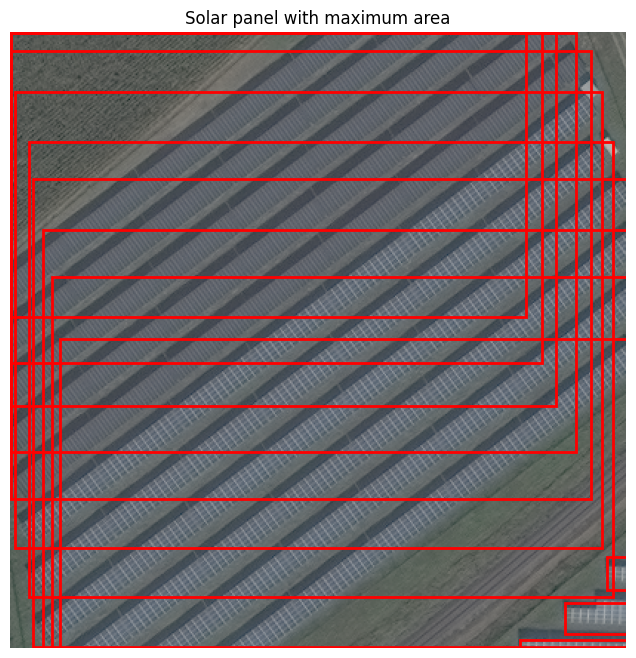

In [32]:
img = Image.open(os.path.join(image_folder, max_area_im_file))
bboxes = []
with open(os.path.join(label_folder, max_area_lab_file)) as fh:
    boxes = np.loadtxt(fh, ndmin=2)
    for box in boxes:
        bboxes.append(convert_to_xyxy(box))
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)
for box in bboxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
plt.title("Solar panel with maximum area")
plt.axis("off")
plt.show()

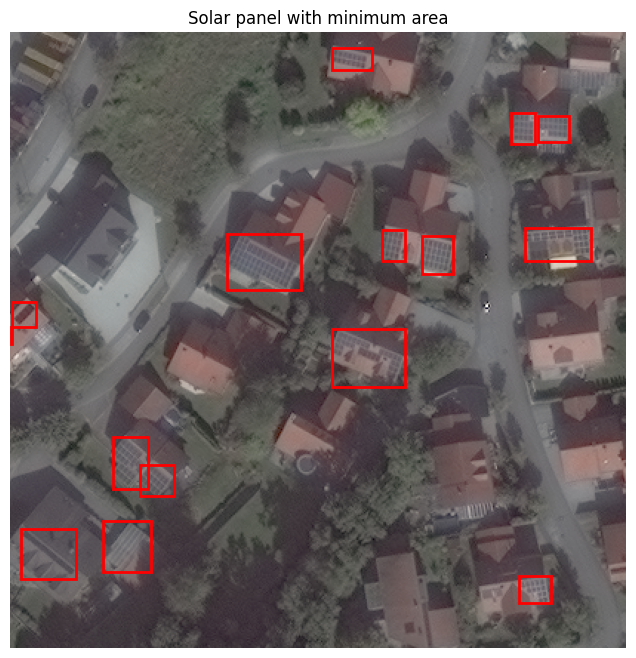

In [34]:
img = Image.open(os.path.join(image_folder, min_area_im_file))
bboxes = []
with open(os.path.join(label_folder, min_area_lab_file)) as fh:
    boxes = np.loadtxt(fh, ndmin=2)
    for box in boxes:
        bboxes.append(convert_to_xyxy(box))
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)
for box in bboxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
plt.title("Solar panel with minimum area")
plt.axis("off")
plt.show()

The standard deviation in areas of solar panels is huge. As we can see from the histogram of areas, this large standard deviation is due to some panels covering areas way larger than the average, they seem to be from solar farms. The smallest panels seem to be ones from residential areas, mostly ones that haven't been captured in their entirety in the images. The images are mostly of residential areas.

# ANALYSING SELF-WRITTEN FUNCTION FOR IOU

In [ ]:
# Comparing IoU calculation using self-written code and supervision library
bboxes_iou_testing = bboxes # using the bboxes from the previous image for testing iou calculation
bboxes_iou_testing.sort(key = lambda x:x[0])
# using the two intersecting boxes from the image plotted above
box1 = np.array([bboxes_iou_testing[4]])
box2 = np.array([bboxes_iou_testing[5]])

print(f"IoU calculated using self-written function = {calc_iou(bboxes_iou_testing[4], bboxes_iou_testing[5], xy = True)}")
print(f"IoU calculated using supervision function = {(sv.box_iou_batch(box1, box2))[0][0]}")

IoU calculated using self-written function = 0.07823960880195599
IoU calculated using supervision function = 0.07823960880195599


In [46]:
def batch_iou(gt, pred, xy):
    ious =[]
    for boxa in gt:
        iou = []
        for boxb in pred:
            iou.append(calc_iou(boxa, boxb, xy))
        ious.append(iou)
    return ious

# FUNCTION FOR AVERAGE PRECISION

In [148]:
ht_gt_bboxes = [] # hypothetical randomly generated ground truth bounding boxes
ht_pr_bboxes = [] # hypothetical randomly generated predicted bounding boxes
for i in range(10): # for the ground truth
    img_boxes = []
    for j in range(10):
        x_min = np.random.randint(0, 80) # ending range at 80, image 100, box 20, therfore max xmin is 80
        y_min = np.random.randint(0, 80) # same for ymin
        x_max = x_min+20
        y_max = y_min+20
        img_boxes.append([x_min, y_min, x_max, y_max])
    ht_gt_bboxes.append(img_boxes)
for i in range(10): # for the predictions
    img_boxes = []
    for j in range(10):
        x_min = np.random.randint(0, 80) 
        x_max = x_min+20
        y_max = y_min+20
        img_boxes.append([x_min, y_min, x_max, y_max])
    ht_pr_bboxes.append(img_boxes)

In [149]:
# computing precision recall curve
for img_num in range(10):
    ious = batch_iou(ht_gt_bboxes[img_num], ht_pr_bboxes[img_num], xy = True)
    y_true = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            if ious[i][j]>=0.5:
                y_true[i][j] = 1
    y_scores = np.array(ious)
    y_true = y_true.flatten()
    y_scores = y_scores.flatten()
precision, recall, _ = precision_recall_curve(y_true, y_scores)

In [150]:
# Pascal VOC 11 point interpolation method
# sampling precision at 11 recall values (0.0, 0.1, ..., 1.0)
def voc_11_point_ap(precision, recall):
    recall_levels = np.linspace(0, 1, 11)
    max_precision = [np.max(precision[recall >= r]) if np.any(recall >= r) else 0 for r in recall_levels]
    return np.mean(max_precision)

In [151]:
# COCO 101 point interpolation method
# sampling precision at 101 recall values (0.00, 0.01, ..., 1.00), more precise than pasc voc
def coco_101_point_ap(precision, recall):
    recall_levels = np.linspace(0, 1, 101)
    max_precision = [np.max(precision[recall >= r]) if np.any(recall >= r) else 0 for r in recall_levels]
    return np.mean(max_precision)

In [152]:
# PR AUC
# are under precision recall curve, direct integration
def pr_auc(precision, recall):
    return np.trapz(precision, recall)

In [153]:
print(f"AP50 computed using 'Pascal VOC 11 Point Interpolation' method = {voc_11_point_ap(precision, recall)}")
print(f"AP50 computed using 'COCO 101 Point Interpolation' method = {coco_101_point_ap(precision, recall)}")
print(f"AP50 computed using 'Area under the precision recall curve' method = {voc_11_point_ap(precision, recall)}")

AP50 computed using 'Pascal VOC 11 Point Interpolation' method = 1.0
AP50 computed using 'COCO 101 Point Interpolation' method = 1.0
AP50 computed using 'Area under the precision recall curve' method = 1.0
